In [1]:
import argparse
import numpy as np
import os
from math import log10, floor
from datetime import datetime
from glob import glob
import stat
import pickle
import math
import array
import scipy
from multiprocessing import Pool
from itertools import repeat
from pathlib import Path
from scipy.signal import correlate
from scipy.fft import ifft, fft, next_fast_len
import qetpy as qp
import matplotlib
import matplotlib.pyplot as plt
import pytesdaq.io.hdf5 as h5io
import yaml
import pytesdaq
from detprocess.core import OptimumFilterTrigger, EventBuilder, Template, Noise, Salting
from detprocess import utils,FilterData
from pprint import pprint
from scipy import stats, signal, interpolate, special, integrate
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import types
import mendeleev
import pickle as pkl
import sys
from darklim import constants

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


In [2]:
#yaml_dict = yaml.load(open('/home/michael/salting/detprocess/examples/processing/process_example.yaml', 'r'), Loader=utils._UniqueKeyLoader)
#salting_dict = yaml_dict['salting']
filter_file = "/home/michael/salting/detprocess/examples/r46testfilterfile.hdf5"
didv_file = "/home/michael/salting/run46tests/pylelab_run46_analysis/didvBOTHCHAN.hdf5"

In [3]:

pdf_file = "/home/michael/salting/detprocess/examples/mass_dict.pkl"


In [4]:
salting = Salting(filter_file, didv_file,verbose=True)

INFO: Loading filter data from file /home/michael/salting/detprocess/examples/r46testfilterfile.hdf5
INFO: Loading filter data from file /home/michael/salting/run46tests/pylelab_run46_analysis/didvBOTHCHAN.hdf5


In [5]:
series = None
restricted=False
salting.set_raw_data_path(group_path="/data/ucb/pylelab/run46/raw/continuous_I2_D20240620_T165135",
                            series=series,
                            restricted=restricted)

In [6]:
template = Template()
template.load_hdf5('./r46testfilterfile.hdf5')
template.describe()

INFO: Loading filter data from file ./r46testfilterfile.hdf5
List of channels: ['Mv3025pcRegular|Mv3025pcBigFins', 'Mv3025pcRegular', 'Mv3025pcBigFins']

Channel Mv3025pcRegular|Mv3025pcBigFins:
 * Tag "default":
    csd: 3D numpy.array  (2, 2, 25000)
 * Tag "freqs_default":
    csd: pandas.Series (25000,)
 * Tag "shared_2x2":
    template: 3D numpy.array  (2, 2, 25000)
 * Tag "shared_Mv3025pcBigFins":
    template: 3D numpy.array  (2, 1, 25000)
 * Tag "shared_Mv3025pcRegular":
    template: 3D numpy.array  (2, 1, 25000)
 * Tag "single_Mv3025pcBigFins":
    template: 3D numpy.array  (2, 1, 25000)
 * Tag "single_Mv3025pcRegular":
    template: 3D numpy.array  (2, 1, 25000)

Channel Mv3025pcRegular:
 * Tag "default":
    psd: pandas.Series (25000,)
    template: pandas.Series (25000,)
 * Tag "singles":
    template: pandas.Series (25000,)

Channel Mv3025pcBigFins:
 * Tag "default":
    psd: pandas.Series (25000,)
    template: pandas.Series (25000,)
 * Tag "singles":
    template: pandas

In [7]:
chan = "Mv3025pcRegular|Mv3025pcBigFins"
template_tag = "shared_Mv3025pcRegular"
noise_tag = "default"
pce = [0.4, 0.3]
dpdi_tag = "default"
dpdi_poles = 3

In [8]:
energies=[0.01,0.1,1,10,100,1000]
#if 'energies' in chan_config:
#    energies = chan_config['energies']


In [9]:
salts,filtsalts = salting.generate_salt(chan,
                        noise_tag=noise_tag,
                        template_tag=template_tag,
                        dpdi_tag=dpdi_tag,
                        dpdi_poles=dpdi_poles,
                        energies=energies,
                        PCE = pce,
                        pdf_file=None,
                        nevents=20)

INFO: Found total of 3 raw data file(s) from 1 different series number!
INFO: Found total of 3 files from 1 different series number!
INFO: Changing number cores to 1 (maximum possible)
INFO Node #1: Acquiring randoms for series I2_D20240620_T165258
INFO: Randoms acquisition done!


In [10]:
salts[1][1]

[array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.06354293e-17, 4.06005117e-17, 4.05656240e-17])]

In [11]:
temp ,time = salting.get_template("Mv3025pcRegular|Mv3025pcBigFins","shared_Mv3025pcRegular")

In [12]:
time

array([0.00000e+00, 8.00000e-07, 1.60000e-06, ..., 1.99976e-02,
       1.99984e-02, 1.99992e-02])

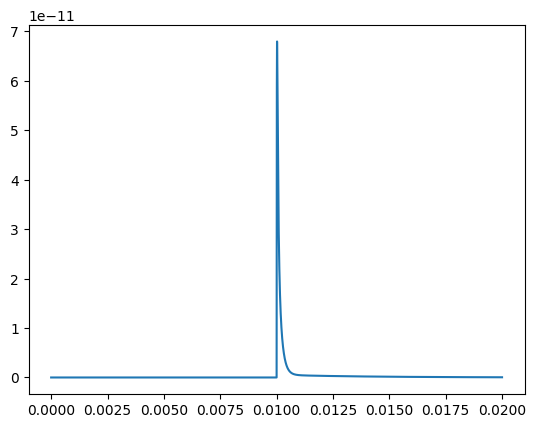

In [13]:
plt.plot(time,salts[0][0][0])

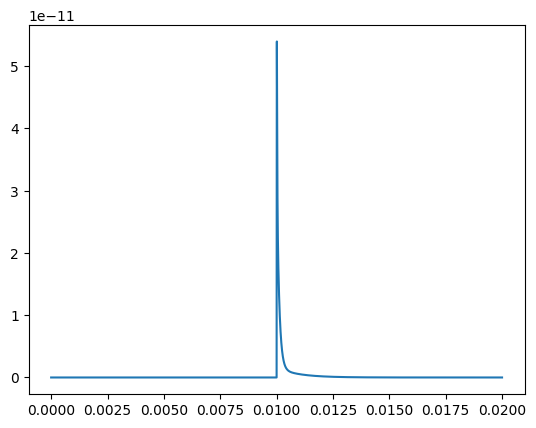

In [14]:
plt.plot(time,salts[0][1][0])

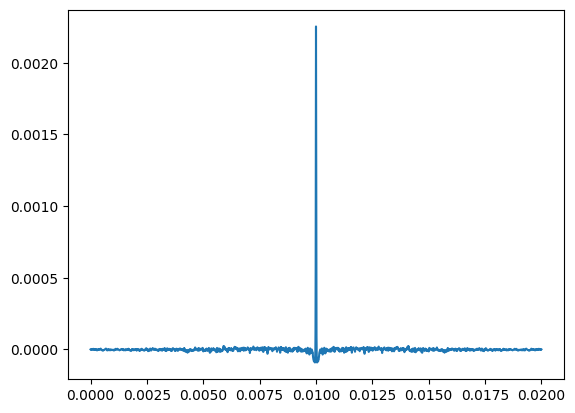

In [15]:
plt.plot(time,filtsalts[0][0][0])

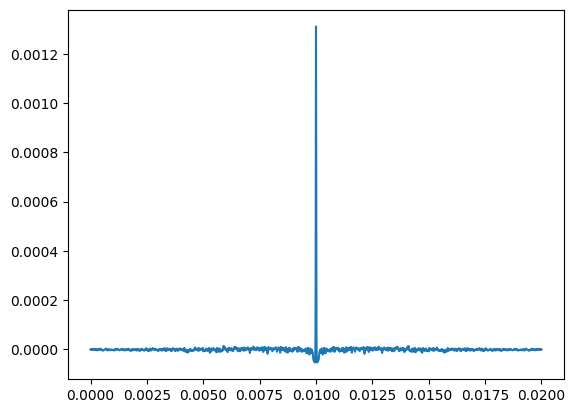

In [16]:
plt.plot(time,filtsalts[0][1][0])

In [17]:
ahh = salting.get_DMenergies()

In [18]:
salting_dataframe = salting.get_dataframe()

In [19]:
salting_dataframe

#,series_number,event_number,dump_number,event_time,series_start_time,group_start_time,fridge_run_start_time,fridge_run_number,trigger_index,trigger_time,trigger_type,data_type,group_name,processing_id,trigger_prod_id,trigger_prod_group_name,salt_template_tag,salt_recoil_energy_eV,salt_amplitude_Mv3025pcRegular,salt_amplitude_Mv3025pcBigFins,salt_filt_amplitude_Mv3025pcRegular,salt_filt_amplitude_Mv3025pcBigFins,salt_energy_eV_Mv3025pcRegular,salt_energy_eV_Mv3025pcBigFins
0,220240620165258,100001,1,1718927591,13,95,291191,46,1500790,1.200632,3,Test,continuous_I2_D20240620_T165135,nan,1,nan,shared_Mv3025pcRegular,0.01,6.79392073282667e-11,5.3964691579676794e-11,0.0022527187445085454,0.001310460941618591,0.005631796861271363,0.004368203138728637
1,220240620165258,100001,1,1718927592,14,96,291192,46,1915448,1.5323584,3,Test,continuous_I2_D20240620_T165135,nan,2,nan,shared_Mv3025pcRegular,0.01,5.797703194898747e-11,6.416674425801216e-11,0.0019223943251412516,0.0015582042561440611,0.004805985812853129,0.00519401418714687
2,220240620165258,100001,1,1718927592,14,96,291192,46,2694831,2.1558648,3,Test,continuous_I2_D20240620_T165135,nan,3,nan,shared_Mv3025pcRegular,0.01,6.634893956085013e-11,5.559325109787074e-11,0.002199988868059772,0.0013500083489551707,0.00549997217014943,0.0045000278298505695
3,220240620165258,100001,1,1718927596,18,100,291196,46,7101435,5.681148,3,Test,continuous_I2_D20240620_T165135,nan,4,nan,shared_Mv3025pcRegular,0.01,2.7458192467981462e-11,9.542044098719095e-11,0.0009104549095498445,0.0023171588178376164,0.002276137273874611,0.007723862726125388
4,220240620165258,100002,1,1718927603,25,107,291203,46,4254966,3.4039728,3,Test,continuous_I2_D20240620_T165135,nan,5,nan,shared_Mv3025pcRegular,0.01,3.0129583511705244e-11,9.268472603388974e-11,0.0009990325205459772,0.0022507256095905172,0.002497581301364943,0.007502418698635057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,220240620165258,300007,3,1718927880,302,384,291480,46,11991430,9.593144,3,Test,continuous_I2_D20240620_T165135,nan,116,nan,shared_Mv3025pcRegular,1000.0,9.280921451023557e-06,2.8495844292691705e-06,307.73549679514065,69.19837740364453,769.3387419878516,230.66125801214844
116,220240620165258,300008,3,1718927883,305,387,291483,46,3605300,2.88424,3,Test,continuous_I2_D20240620_T165135,nan,117,nan,shared_Mv3025pcRegular,1000.0,5.6609987578339405e-06,6.556670542633104e-06,187.70660588950176,159.22004558287367,469.26651472375437,530.7334852762456
117,220240620165258,300008,3,1718927884,306,388,291484,46,5129070,4.103256,3,Test,continuous_I2_D20240620_T165135,nan,118,nan,shared_Mv3025pcRegular,1000.0,5.63676281725158e-06,6.581490055753153e-06,186.90299395778052,159.8227545316646,467.2574848944513,532.7425151055487
118,220240620165258,300008,3,1718927885,307,389,291485,46,5783689,4.6269512,3,Test,continuous_I2_D20240620_T165135,nan,119,nan,shared_Mv3025pcRegular,1000.0,7.0646184007731665e-06,5.119253413097656e-06,234.24762990427598,124.31427757179301,585.61907476069,414.38092523931005


In [20]:
for dm_mass in salting_dataframe['salt_dm_mass_MeV'].unique():
    # Filter the data for the current dark matter mass
    filtered_data = salting_dataframe[salting_dataframe['salt_dm_mass_MeV'] == dm_mass]
    
    # Plot histogram for 'salt_recoil_energy_eV' for the current dark matter mass
    plt.hist(filtered_data['salt_recoil_energy_eV'], bins=30, alpha=0.5, label=f"{dm_mass} MeV")
    
# Add legend and labels
plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Frequency')
plt.title('Histogram of Recoil Energy by Dark Matter Mass')
plt.legend(title='DM Mass (MeV)')
plt.show()

NameError: Column or variable 'salt_dm_mass_MeV' does not exist.

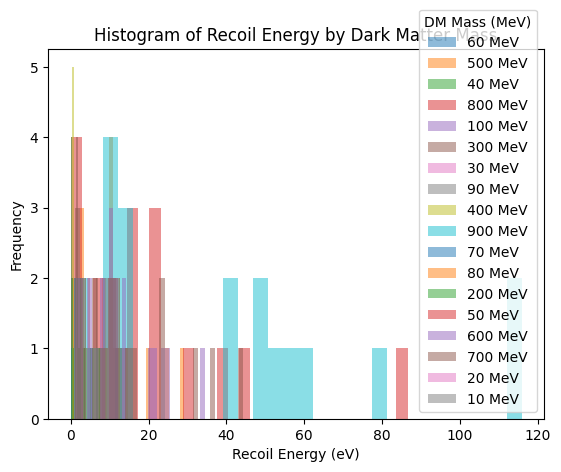

In [21]:
for dm_mass in salting_dataframe['salt_dm_mass_MeV'].unique():
    # Filter the data for the current dark matter mass
    filtered_data = salting_dataframe[salting_dataframe['salt_dm_mass_MeV'] == dm_mass]
    
    # Plot histogram for 'salt_recoil_energy_eV' for the current dark matter mass
    plt.hist(filtered_data['salt_energy_eV_Mv3025pcRegular'], bins=30, alpha=0.5, label=f"{dm_mass} MeV")
    
# Add legend and labels
plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Frequency')
plt.title('Histogram of Recoil Energy by Dark Matter Mass')
plt.legend(title='DM Mass (MeV)')
plt.show()

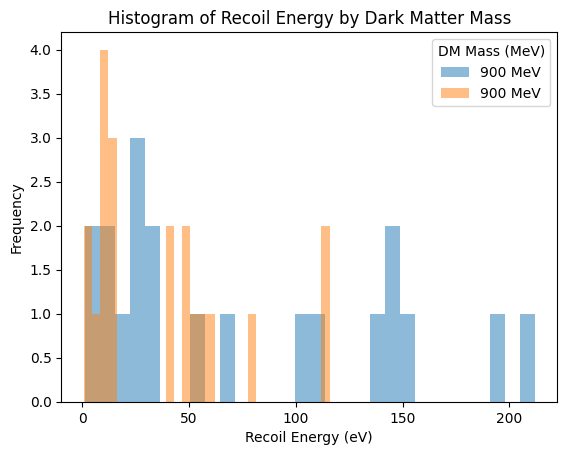

In [22]:
dm_mass = 900
filtered_data = salting_dataframe[salting_dataframe['salt_dm_mass_MeV'] == dm_mass]
plt.hist(filtered_data['salt_recoil_energy_eV'], bins=30, alpha=0.5, label=f"{dm_mass} MeV")
plt.hist(filtered_data['salt_energy_eV_Mv3025pcRegular'], bins=30, alpha=0.5, label=f"{dm_mass} MeV")
plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Frequency')
plt.title('Histogram of Recoil Energy by Dark Matter Mass')
plt.legend(title='DM Mass (MeV)')
plt.show()

In [21]:
salts,filtsalts = salting.generate_salt(chan,
                        noise_tag=noise_tag,
                        template_tag=template_tag,
                        dpdi_tag=dpdi_tag,
                        dpdi_poles=dpdi_poles,
                        energies=energies,
                        PCE = pce,
                        pdf_file=None,
                        nevents=20)

INFO: Found total of 3 raw data file(s) from 1 different series number!
INFO: Found total of 3 files from 1 different series number!
INFO: Changing number cores to 1 (maximum possible)
INFO Node #1: Acquiring randoms for series I2_D20240620_T165258
INFO: Randoms acquisition done!


In [22]:
chan = "Mv3025pcBigFins"
template_tag = 'default'
noise_tag = "default"
pce = [0.4]
dpdi_tag = "default"
dpdi_poles = 3

In [23]:
#salting.load_hdf5('./r46testfilterfile.hdf5')
#salting.load_hdf5(didv_file)

In [24]:
salts,filtsalts = salting.generate_salt(chan,
                        noise_tag=noise_tag,
                        template_tag=template_tag,
                        dpdi_tag=dpdi_tag,
                        dpdi_poles=dpdi_poles,
                        energies=energies,
                        PCE = pce,
                        pdf_file=None,
                        nevents=100)

INFO: Found total of 3 raw data file(s) from 1 different series number!
INFO: Found total of 3 files from 1 different series number!
INFO: Changing number cores to 1 (maximum possible)
INFO Node #1: Acquiring randoms for series I2_D20240620_T165258
INFO: Randoms acquisition done!
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.33278653e-07
 6.32734482e-07 6.32190779e-07]


In [25]:
salting_dataframe = salting.get_dataframe()

In [26]:
salting_dataframe

#,series_number,event_number,dump_number,event_time,series_start_time,group_start_time,fridge_run_start_time,fridge_run_number,trigger_index,trigger_time,trigger_type,data_type,group_name,processing_id,trigger_prod_id,trigger_prod_group_name,salt_template_tag,salt_recoil_energy_eV,salt_amplitude_Mv3025pcRegular,salt_amplitude_Mv3025pcBigFins,salt_filt_amplitude_Mv3025pcRegular,salt_filt_amplitude_Mv3025pcBigFins,salt_energy_eV_Mv3025pcRegular,salt_energy_eV_Mv3025pcBigFins
0,220240620165258,100001,1,1718927591,13,95,291191,46,1500790,1.200632,3,Test,continuous_I2_D20240620_T165135,0.0,1,0.0,shared_Mv3025pcRegular,0.01,6.79392073282667e-11,5.3964691579676794e-11,0.0022527187445085454,0.001310460941618591,0.005631796861271363,0.004368203138728637
1,220240620165258,100001,1,1718927592,14,96,291192,46,1915448,1.5323584,3,Test,continuous_I2_D20240620_T165135,0.0,2,0.0,shared_Mv3025pcRegular,0.01,5.797703194898747e-11,6.416674425801216e-11,0.0019223943251412516,0.0015582042561440611,0.004805985812853129,0.00519401418714687
2,220240620165258,100001,1,1718927592,14,96,291192,46,2694831,2.1558648,3,Test,continuous_I2_D20240620_T165135,0.0,3,0.0,shared_Mv3025pcRegular,0.01,6.634893956085013e-11,5.559325109787074e-11,0.002199988868059772,0.0013500083489551707,0.00549997217014943,0.0045000278298505695
3,220240620165258,100001,1,1718927596,18,100,291196,46,7101435,5.681148,3,Test,continuous_I2_D20240620_T165135,0.0,4,0.0,shared_Mv3025pcRegular,0.01,2.7458192467981462e-11,9.542044098719095e-11,0.0009104549095498445,0.0023171588178376164,0.002276137273874611,0.007723862726125388
4,220240620165258,100002,1,1718927603,25,107,291203,46,4254966,3.4039728,3,Test,continuous_I2_D20240620_T165135,0.0,5,0.0,shared_Mv3025pcRegular,0.01,3.0129583511705244e-11,9.268472603388974e-11,0.0009990325205459772,0.0022507256095905172,0.002497581301364943,0.007502418698635057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,220240620165258,300008,3,1718927889,311,393,291489,46,10842447,8.6739576,3,Test,continuous_I2_D20240620_T165135,0.0,566,0.0,default,1000.0,0.0,1.647197252991709e-05,0.0,400.0,0.0,1000.0
806,220240620165258,300008,3,1718927889,311,393,291489,46,11187506,8.9500048,3,Test,continuous_I2_D20240620_T165135,0.0,567,0.0,default,1000.0,0.0,1.647197252991709e-05,0.0,400.0,0.0,1000.0
807,220240620165258,300008,3,1718927890,312,394,291490,46,11923497,9.5387976,3,Test,continuous_I2_D20240620_T165135,0.0,568,0.0,default,1000.0,0.0,1.647197252991709e-05,0.0,400.0,0.0,1000.0
808,220240620165258,300008,3,1718927890,312,394,291490,46,12053121,9.6424968,3,Test,continuous_I2_D20240620_T165135,0.0,569,0.0,default,1000.0,0.0,1.647197252991709e-05,0.0,400.0,0.0,1000.0


In [27]:
eventID = 100001
seriesID = 220240620165258
filtered_df = salting_dataframe[(salting_dataframe['event_number'] == eventID) & (salting_dataframe['series_number'] == seriesID)]

In [28]:
filtered_df

#,series_number,event_number,dump_number,event_time,series_start_time,group_start_time,fridge_run_start_time,fridge_run_number,trigger_index,trigger_time,trigger_type,data_type,group_name,processing_id,trigger_prod_id,trigger_prod_group_name,salt_template_tag,salt_recoil_energy_eV,salt_amplitude_Mv3025pcRegular,salt_amplitude_Mv3025pcBigFins,salt_filt_amplitude_Mv3025pcRegular,salt_filt_amplitude_Mv3025pcBigFins,salt_energy_eV_Mv3025pcRegular,salt_energy_eV_Mv3025pcBigFins
0,220240620165258,100001,1,1718927591,13,95,291191,46,1500790,1.200632,3,Test,continuous_I2_D20240620_T165135,0.0,1,0.0,shared_Mv3025pcRegular,0.01,6.79392073282667e-11,5.3964691579676794e-11,0.0022527187445085454,0.001310460941618591,0.005631796861271363,0.004368203138728637
1,220240620165258,100001,1,1718927592,14,96,291192,46,1915448,1.5323584,3,Test,continuous_I2_D20240620_T165135,0.0,2,0.0,shared_Mv3025pcRegular,0.01,5.797703194898747e-11,6.416674425801216e-11,0.0019223943251412516,0.0015582042561440611,0.004805985812853129,0.00519401418714687
2,220240620165258,100001,1,1718927592,14,96,291192,46,2694831,2.1558648,3,Test,continuous_I2_D20240620_T165135,0.0,3,0.0,shared_Mv3025pcRegular,0.01,6.634893956085013e-11,5.559325109787074e-11,0.002199988868059772,0.0013500083489551707,0.00549997217014943,0.0045000278298505695
3,220240620165258,100001,1,1718927596,18,100,291196,46,7101435,5.681148,3,Test,continuous_I2_D20240620_T165135,0.0,4,0.0,shared_Mv3025pcRegular,0.01,2.7458192467981462e-11,9.542044098719095e-11,0.0009104549095498445,0.0023171588178376164,0.002276137273874611,0.007723862726125388
4,220240620165258,100001,1,1718927590,12,94,291190,46,473432,0.3787456,3,Test,continuous_I2_D20240620_T165135,0.0,1,0.0,shared_Mv3025pcRegular,0.01,6.373873366936398e-11,5.826630763345744e-11,0.002113440025793091,0.0014149199806551818,0.005283600064482728,0.004716399935517273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,220240620165258,100001,1,1718927597,19,101,291197,46,8904007,7.1232056,3,Test,continuous_I2_D20240620_T165135,0.0,15,0.0,default,0.01,0.0,1.647197252991709e-10,0.0,0.003999999999999999,0.0,0.01
23,220240620165258,100001,1,1718927597,19,101,291197,46,8926643,7.1413144,3,Test,continuous_I2_D20240620_T165135,0.0,16,0.0,default,0.01,0.0,1.647197252991709e-10,0.0,0.003999999999999999,0.0,0.01
24,220240620165258,100001,1,1718927597,19,101,291197,46,9258674,7.4069392,3,Test,continuous_I2_D20240620_T165135,0.0,17,0.0,default,0.01,0.0,1.647197252991709e-10,0.0,0.003999999999999999,0.0,0.01
25,220240620165258,100001,1,1718927598,20,102,291198,46,10049768,8.0398144,3,Test,continuous_I2_D20240620_T165135,0.0,18,0.0,default,0.01,0.0,1.647197252991709e-10,0.0,0.003999999999999999,0.0,0.01


In [29]:
seriesnum = 220240620165258
eventnum = 100001
chans = ['Mv3025pcRegular','Mv3025pcBigFins']

In [30]:
channels=['Mv3025pcRegular','Mv3025pcBigFins']
continuous_data = '/data/ucb/pylelab/run46/raw/continuous_I2_D20240620_T165135'
continuous_data_series = 'None'
h5 = h5io.H5Reader()
h5.set_files(continuous_data, series=None)
mtraces, mtraces_info = h5.read_many_events(nevents=1, detector_chans=channels, include_metadata=True, adctoamp=True)

In [31]:
newtrace = salting.inject_raw_salt(channels,mtraces,seriesnum,eventnum)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [32]:
newtrace

[array([-3.03431749e-07, -3.13682532e-07, -3.21183109e-07, ...,
        -2.93681002e-07, -3.01931643e-07, -2.96431208e-07]),
 array([-2.37921214e-07, -2.43919635e-07, -2.49418187e-07, ...,
        -2.35671806e-07, -2.37421346e-07, -2.36171675e-07])]

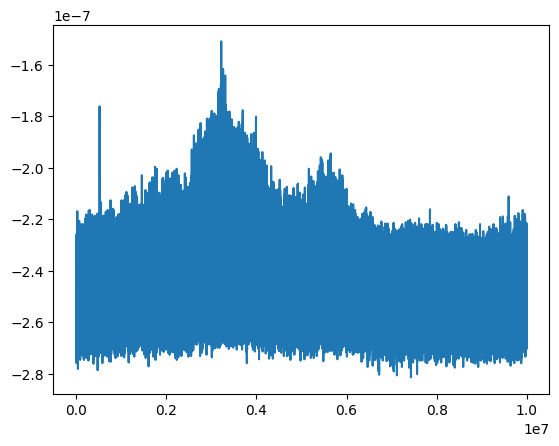

In [33]:
fs = 1.25e6
dt = 1/fs
bins = np.asarray(list(range(int(1.25e7))))*dt*1e6
plt.plot(bins,mtraces[0][1])
#plt.xlim(5e5,5.5e5)
#plt.xlim(9e3,1.1e4)
#plt.ylim(-0.2,0.2)
#plt.xlim(9000,11000)

In [34]:
newtrace[0]

array([-3.03431749e-07, -3.13682532e-07, -3.21183109e-07, ...,
       -2.93681002e-07, -3.01931643e-07, -2.96431208e-07])

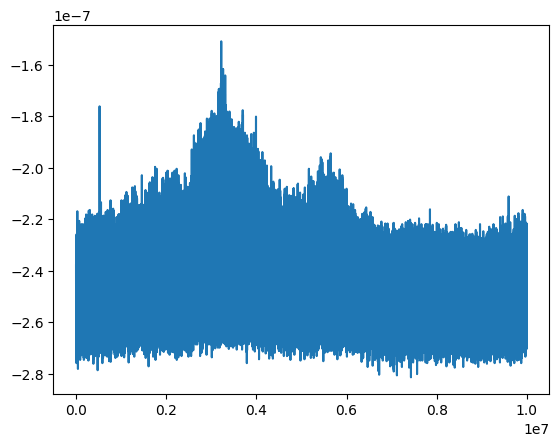

In [35]:
fs = 1.25e6
dt = 1/fs
bins = np.asarray(list(range(int(1.25e7))))*dt*1e6
plt.plot(bins,newtrace[1])
#plt.xlim(5e5,5.5e5)
#plt.xlim(9e3,1.1e4)
#plt.ylim(-0.2,0.2)
#plt.xlim(9000,11000)

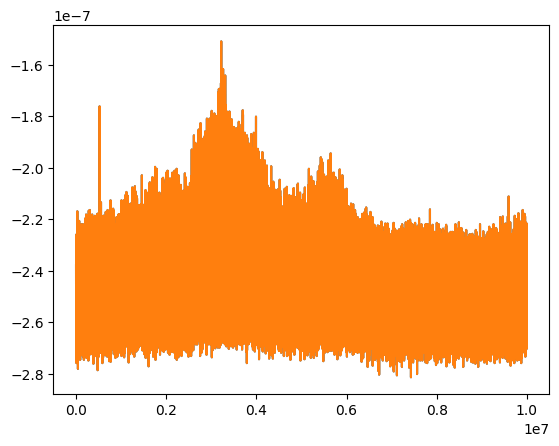

In [36]:
fs = 1.25e6
dt = 1/fs
bins = np.asarray(list(range(int(1.25e7))))*dt*1e6
plt.plot(bins,newtrace[1])
plt.plot(bins,mtraces[0][1])
#plt.xlim(5e5,5.5e5)
#plt.xlim(9e3,1.1e4)
#plt.ylim(-0.2,0.2)
#plt.xlim(9000,11000)

In [37]:
justpulses = newtrace[1] - mtraces[0][1]

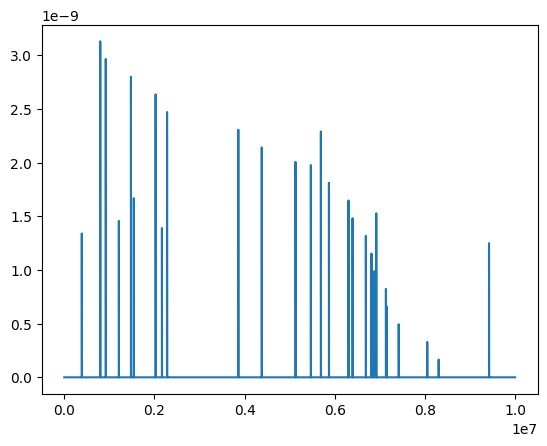

In [38]:
fs = 1.25e6
dt = 1/fs
bins = np.asarray(list(range(int(1.25e7))))*dt*1e6
plt.plot(bins,justpulses)